In [ ]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

from google.colab import output
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/drive/MyDrive/Colab Notebooks/동서발전 태양광 발전량 예측 경진대회/data.zip" "data.zip"
# data.zip을 현재 디렉터리에 압축해제
!unzip "data.zip"
output.clear()

In [ ]:
# import library 
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
import glob
import pickle

# path
path = "./"
dangjin_fcst_data_path = path + "dangjin_fcst_data.csv"
dangjin_obs_data_path = path + "dangjin_obs_data.csv"
energy_data_path = path + "energy.csv"
ulsan_fcst_data_path = path + "ulsan_fcst_data.csv"
ulsan_obs_data_path = path + "ulsan_obs_data.csv"
site_info_path = path + "site_info.csv"

# file convert to pandas data
dangjin_fcst_data = pd.read_csv(dangjin_fcst_data_path)
dangjin_obs_data = pd.read_csv(dangjin_obs_data_path)
energy_data = pd.read_csv(energy_data_path)
ulsan_fcst_data = pd.read_csv(ulsan_fcst_data_path)
ulsan_obs_data = pd.read_csv(ulsan_obs_data_path)
site_info = pd.read_csv(site_info_path)

# ======================================================================== #
# ===================== load data and preprocessing ====================== #
# ======================================================================== #

dangjin_obs_data.rename(
    columns = {
        "일시":"time",
        "기온(°C)":"Temperature",
        "풍속(m/s)":"WindSpeed",
        "풍향(16방위)":"WindDirection",
        "습도(%)":"Humidity",
        "전운량(10분위)":"Cloud"
    }, inplace = True)

ulsan_obs_data.rename(
    columns = {
        "일시":"time",
        "기온(°C)":"Temperature",
        "풍속(m/s)":"WindSpeed",
        "풍향(16방위)":"WindDirection",
        "습도(%)":"Humidity",
        "전운량(10분위)":"Cloud"
    }, inplace = True)


def preprocess_wind_NN(data):
    '''
    - data: pd.DataFrmae which contains the columns 'WindSpeed' and 'WindDirection'
    - for Neural Network version
    '''
    # degree to radian
    wind_direction_radian = data['WindDirection'] * np.pi / 180

    # polar coordinate to cartesian coordinate
    wind_x = data['WindSpeed'] * np.cos(wind_direction_radian)
    wind_y = data['WindDirection'] * np.sin(wind_direction_radian)

    # name pd.series
    wind_x.name = 'Wind_X'
    wind_y.name = 'Wind_Y'

    return wind_x, wind_y

dangjin_obs_data = dangjin_obs_data.drop(columns = ["지점", "지점명"])
ulsan_obs_data = ulsan_obs_data.drop(columns = ["지점","지점명"])

# time: convert datatype object
dangjin_obs_data["time"] = pd.to_datetime(dangjin_obs_data["time"].copy(), format='%Y-%m-%d %H:%M:%S')
dangjin_obs_data = dangjin_obs_data.astype({"time":"object"})

ulsan_obs_data["time"] = pd.to_datetime(ulsan_obs_data["time"].copy(), format='%Y-%m-%d %H:%M:%S')
ulsan_obs_data = ulsan_obs_data.astype({"time":"object"})

# energy_data, time: string -> timestamp
import datetime as dt

energy_data_time_tmp = energy_data["time"].copy()

for i in range(energy_data.shape[0]):
    if energy_data["time"][i][-8:] == "24:00:00":
        energy_data["time"][i] = energy_data_time_tmp[i].replace("24:00:00", " 00:00:00")
        energy_data["time"][i] = pd.to_datetime(energy_data["time"][i]) + dt.timedelta(days = 1)

    energy_data["time"][i] = pd.Timestamp(energy_data["time"][i])

# object 
energy_data = energy_data.astype({"time":"object"})
dangjin_obs_data = dangjin_obs_data.astype({"time":"object"})
ulsan_obs_data = ulsan_obs_data.astype({"time":"object"})

# 전 데이터 NAN 처리
dangjin_obs_data = dangjin_obs_data.fillna(method = "bfill")
energy_data = energy_data.fillna(method = "bfill")
ulsan_obs_data = ulsan_obs_data.fillna(method = "bfill")

# Wind_X, Wind_Y variable add
dangjin_obs_data = dangjin_obs_data.join(preprocess_wind_NN(dangjin_obs_data))
ulsan_obs_data = ulsan_obs_data.join(preprocess_wind_NN(ulsan_obs_data))

# total dataset 구성
from functools import reduce

list_dangjin = [dangjin_obs_data, energy_data[["time","dangjin_floating","dangjin_warehouse","dangjin"]].copy()]
list_ulsan = [ulsan_obs_data, energy_data[["time","ulsan"]].copy()]

dangjin_data = reduce(lambda  left,right: pd.merge(left, right, on=['time'], how='inner'), list_dangjin)
ulsan_data = reduce(lambda  left,right: pd.merge(left, right, on=['time'], how='inner'), list_ulsan)

 # function for day_of_year
def day_of_year(datetime): #pd.datetime
    return pd.Period(datetime, freq='D').dayofyear

# function
def add_seasonality(df):
    new_df = df.copy()
    
    new_df['Day_cos'] = new_df['time'].apply(lambda x: np.cos(x.hour * (2 * np.pi) / 24))
    new_df['Day_sin'] = new_df['time'].apply(lambda x: np.sin(x.hour * (2 * np.pi) / 24))

    new_df['Year_cos'] = new_df['time'].apply(lambda x: np.cos(day_of_year(x) * (2 * np.pi) / 365))
    new_df['Year_sin'] = new_df['time'].apply(lambda x: np.sin(day_of_year(x) * (2 * np.pi) / 365))

    return new_df

dangjin_data = add_seasonality(dangjin_data)
ulsan_data = add_seasonality(ulsan_data)

from sklearn.preprocessing import MinMaxScaler

def preprocessing(data, col_name):
    # col_name: column name(string type)
    # data: pd.DataFrame
    
    data_np = data[col_name].values
    
    scaler = MinMaxScaler()
    data_np = scaler.fit_transform(data_np).reshape(-1, len(col_name))
    
    data = data.drop(columns = col_name)
    data[col_name] = data_np
    
    return data, scaler
    
def PG_preprocessing(data, name = "ulsan"):
    data_np = data[name].values.reshape(-1,1)
    
    scaler = MinMaxScaler()
    
    data_np = scaler.fit_transform(data_np).reshape(-1,1)
    
    data = data.drop(columns = name)
    data[name] = data_np
    
    return data, scaler

def PG_inverse(y, scaler):
    # ulsan, dangjin_floating, warehouse, dangjin data scaler
    # inverse transform to its own unit
    
    if y.shape[1] != 1:
        y = y.reshape(-1,1)
    y_rs = scaler.inverse_transform(y).reshape(-1,1)
    return y_rs

'''
col_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
ulsan_data, ulsan_scaler_mv = preprocessing(ulsan_data, col_name)
dangjin_data, dangjin_scaler_mv = preprocessing(dangjin_data, col_name)


ulsan_data, ulsan_scaler = PG_preprocessing(ulsan_data, "ulsan")
dangjin_data, dangjin_floating_scaler = PG_preprocessing(dangjin_data, "dangjin_floating")
dangjin_data, dangjin_warehouse_scaler = PG_preprocessing(dangjin_data, "dangjin_warehouse")
dangjin_data, dangjin_scaler = PG_preprocessing(dangjin_data, "dangjin")
'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'\ncol_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]\nulsan_data, ulsan_scaler_mv = preprocessing(ulsan_data, col_name)\ndangjin_data, dangjin_scaler_mv = preprocessing(dangjin_data, col_name)\n\n\nulsan_data, ulsan_scaler = PG_preprocessing(ulsan_data, "ulsan")\ndangjin_data, dangjin_floating_scaler = PG_preprocessing(dangjin_data, "dangjin_floating")\ndangjin_data, dangjin_warehouse_scaler = PG_preprocessing(dangjin_data, "dangjin_warehouse")\ndangjin_data, dangjin_scaler = PG_preprocessing(dangjin_data, "dangjin")\n'

In [ ]:
# ======================================================================== #
# ================== build model and training(CNN_LSTM) ================== #
# ======================================================================== #

# CNN_LSTM model 

class CNN_LSTM(tf.keras.models.Model):
    def __init__(self, filters = 64, kernel_size = 3, strides = 1, pool_size = 2, dropout = 0.2, units = 128, n_predict = 24):
        super(CNN_LSTM, self).__init__()
        # batch_normalize
        self.batch1 = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())
        # Conv1
        self.conv1 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv1D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "valid", kernel_initializer = "glorot_uniform", activation = "relu", name = "conv1", kernel_regularizer= tf.keras.regularizers.l2(0.001))
        )
         # Conv2
        self.conv2 =  tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv1D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = "valid", kernel_initializer = "glorot_uniform", activation = "relu", name = "conv2", kernel_regularizer= tf.keras.regularizers.l2(0.001))
        )
        self.batch2 = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())
        # connection between CNN and RNN
        self.avgpool = tf.keras.layers.TimeDistributed(
            tf.keras.layers.AveragePooling1D(pool_size = pool_size)
        )

        self.dropout1 = tf.keras.layers.Dropout(dropout)

        # Conv3
        self.conv3 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv1D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = "valid", kernel_initializer = "glorot_uniform", activation = "relu", name = "conv1", kernel_regularizer= tf.keras.regularizers.l2(0.001))
        )       
        # Conv4
        self.conv4 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv1D(filters = filters*4, kernel_size = kernel_size, strides = strides, padding = "valid", kernel_initializer = "glorot_uniform", activation = "relu", name = "conv1", kernel_regularizer= tf.keras.regularizers.l2(0.001))
        )          
        self.batch2_ = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())
        self.avgpool_ = tf.keras.layers.TimeDistributed(
            tf.keras.layers.AveragePooling1D(pool_size = pool_size)
        )

        self.dropout2 = tf.keras.layers.Dropout(dropout)

        self.flatten = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Flatten()
        )
        

        # RNN
        self.lstm1 = tf.keras.layers.LSTM(units = units, activation = "tanh", recurrent_activation = "tanh", return_sequences = False, kernel_regularizer= tf.keras.regularizers.l2(0.01))
        self.repeat = tf.keras.layers.RepeatVector(n_predict)
        self.lstm2 = tf.keras.layers.LSTM(units = units, activation = "tanh", recurrent_activation = "tanh", return_sequences = True, kernel_regularizer= tf.keras.regularizers.l2(0.01))

        self.batch3 = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())

        # Regression
        self.dense_1 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(64, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))
        )

        self.batch4 = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())

        self.dense_2 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(64, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))
        )
        self.output_layer = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(1, name = "output")
        )

    def predict(self, x):
        # 값을 호출하기 위한 목적
        x = self.batch1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.avgpool(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.batch2_(x)
        x = self.avgpool_(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.lstm1(x)
        x = self.repeat(x)
        x = self.lstm2(x)
        x = self.batch3(x)
        x = self.dense_1(x)
        x = self.batch4(x)
        x = self.dense_2(x)
        outputs = self.output_layer(x)

        return outputs

    def call(self, x):
        x = self.batch1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.avgpool(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.batch2_(x)
        x = self.avgpool_(x)   
        x = self.dropout2(x)     
        x = self.flatten(x)
        x = self.lstm1(x)
        x = self.repeat(x)
        x = self.lstm2(x)
        x = self.batch3(x)
        x = self.dense_1(x)
        x = self.batch4(x)
        x = self.dense_2(x)
        outputs = self.output_layer(x)

        return outputs

    def forecast(self, x, n_predict):

        # x: 처음 인풋값

        preds = []

        for i in range(n_predict):
            pred = self.predict(x)
            preds.append(pred)

        preds = np.array(preds)

        return preds

In [ ]:
# TPU 초기화

import scipy as sp

print('Pandas: %s'%(pd.__version__))
print('Numpy: %s'%(np.__version__))
print('Scipy: %s'%(sp.__version__))
print('Tensorflow: %s'%(tf.__version__))
print('Keras: %s'%(tf.keras.__version__))

# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Pandas: 1.1.5
Numpy: 1.19.5
Scipy: 1.4.1
Tensorflow: 2.4.1
Keras: 2.4.0
Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [ ]:
# ulsan model training
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["ulsan"]

n_features = len(x_name)
n_in = 24 * 1
n_out = 24 * 1
n_timesteps = n_in
input_shape = (1, n_timesteps, n_features)


def series_to_supervised(data, x_name, y_name, n_in, n_out, dropnan = False):

    # x_name: Temp...etc except PG
    # y_name: PG
    # n_in and n_out: equal

    data_copy = data.copy()
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        #cols.append(data_copy[x_name].shift(i)) # col: [data_copy.shift(n_in), .... data_copy.shift(1)]
        cols.append(data_copy[x_name].shift(i))
        names += [("%s(t-%d)"%(name, i)) for name in x_name]
    
    for i in range(n_out, 0, -1):
        y = data_copy[y_name]
        cols.append(y.shift(i))
        # cols:[data_copy.shift(n_in-1), .... data_copy.shift(1), data_copy[y_name].shift(0)....data_copy[y_name].shift(-n_out + 1)]

        names += [("%s(t-%d)"%(name, i)) for name in y_name]

    agg = pd.concat(cols, axis = 1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace = True)
    
    return agg


tf.debugging.set_log_device_placement(True)
with tf.device("/device:gpu:0"):
        
    inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
    outputs = CNN_LSTM(filters = 128, 
                    kernel_size = 3, 
                    strides = 1, 
                    pool_size = 2, 
                    dropout = 0.2, 
                    units = 256, 
                    n_predict = n_out)(inputs)

    model = tf.keras.models.Model(inputs, outputs, name = "CNN_LSTM_model")
    model.summary()

    # custom metric
    import tensorflow.keras.backend as K

    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }

    '''
    def sola_nmae(y_true, y_pred, cap = "ulsan"):

        if type(y_pred) is tf.float32:
            y_true = y_true.numpy()
            y_pred = y_pred.numpy()

        abs_err = np.abs(y_true - y_pred)
        abs_err /= capacity[cap]
        target_idx = np.where(y_pred >= capacity[cap] * 0.1)
        result = 100 * abs_err[target_idx].mean()
        return result

    eval_ulsan = lambda x,y : sola_nmae(x, y, cap = "ulsan")

    def custom_loss(y_true, y_pred):
        loss = tf.py_function(func = eval_ulsan, inp = [y_true, y_pred], Tout = tf.float32, name = "custom_nmae")
        print(loss)
        return loss

    '''

    # callbacks
    #es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 16, mode = "min")
    mc = tf.keras.callbacks.ModelCheckpoint("ulsan_weights.h5", monitor = "val_loss", save_best_only = True, save_weights_only = True, mode = "min")
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.sqrt(0.1), patience = 16, verbose = 0, mode = "min")
    decay = 1e-6
    #callbacks_params = [es, mc, lr]
    callbacks_params = [mc, lr]

    model.compile(
        #loss = tf.keras.losses.Huber(),
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.RMSprop(lr = 1e-3),
        run_eagerly = True
    )

    ulsan_supervised = series_to_supervised(
        ulsan_data.iloc[:-24*30,:], 
        x_name = x_name, 
        y_name = y_name, 
        n_in = n_in, 
        n_out = n_out, 
        dropnan = True)

    x, y = ulsan_supervised.iloc[:,:-n_out].values, ulsan_supervised.iloc[:,- n_out:].values
    x = x.reshape(-1, 1, n_timesteps, n_features).astype("float32")
    y = y.reshape(-1, n_out, 1).astype("float32")

    from sklearn.model_selection import train_test_split

    #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)
    model.fit(x, y, validation_split = 0.3, epochs = 64, batch_size = 128, callbacks = callbacks_params, use_multiprocessing = True)
model.save_weights("ulsan_weights.h5")

Model: "CNN_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 24, 9)]        0         
_________________________________________________________________
cnn_lstm_27 (CNN_LSTM)       (None, 24, 1)             3079141   
Total params: 3,079,141
Trainable params: 3,076,947
Non-trainable params: 2,194
_________________________________________________________________
Epoch 1/64
 36/137 [======>.......................] - ETA: 18s - loss: 13941.4351

Exception ignored in: <function MediaFileUpload.__del__ at 0x7f9f13427290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/http.py", line 587, in __del__
    self._fd.close()
AttributeError: 'MediaFileUpload' object has no attribute '_fd'


137/137 [==============================] - 29s 212ms/step - loss: 12463.7423 - val_loss: 9466.5029
Epoch 2/64
137/137 [==============================] - 29s 211ms/step - loss: 5135.8327 - val_loss: 3851.7854
Epoch 3/64
137/137 [==============================] - 29s 211ms/step - loss: 2551.2419 - val_loss: 3495.8538
Epoch 4/64
137/137 [==============================] - 29s 210ms/step - loss: 1956.5312 - val_loss: 3932.4224
Epoch 5/64
137/137 [==============================] - 29s 211ms/step - loss: 1614.0076 - val_loss: 2436.3591
Epoch 6/64
137/137 [==============================] - 29s 212ms/step - loss: 1399.2312 - val_loss: 2139.1907
Epoch 7/64
137/137 [==============================] - 29s 212ms/step - loss: 1173.9948 - val_loss: 1862.1754
Epoch 8/64
137/137 [==============================] - 28s 208ms/step - loss: 1048.0028 - val_loss: 1480.1299
Epoch 9/64
137/137 [==============================] - 29s 212ms/step - loss: 966.5308 - val_loss: 2073.5256
Epoch 10/64
137/137 [=========

In [ ]:
# dangjin_floating model training
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["dangjin_floating"]

n_features = len(x_name)
n_in = 24 * 1
n_out = 24 * 1
n_timesteps = n_in
input_shape = (1, n_timesteps, n_features)

tf.debugging.set_log_device_placement(True)
with tf.device("/device:gpu:0"):
        
    inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
    outputs = CNN_LSTM(filters = 128, 
                    kernel_size = 3, 
                    strides = 1, 
                    pool_size = 2, 
                    dropout = 0.2, 
                    units = 512, 
                    n_predict = n_out)(inputs)

    model = tf.keras.models.Model(inputs, outputs, name = "CNN_LSTM_model")
    model.summary()

    # custom metric
    import tensorflow.keras.backend as K

    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }

    # callbacks
    #es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 16, mode = "min")
    mc = tf.keras.callbacks.ModelCheckpoint("dangjin_floating_weights.h5", monitor = "val_loss", save_best_only = True, save_weights_only = True, mode = "min")
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.sqrt(0.1), patience = 16, verbose = 0, mode = "min")
    decay = 1e-6
    #callbacks_params = [es, mc, lr]
    callbacks_params = [mc, lr]

    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.RMSprop(lr = 1e-3),
        run_eagerly = True
    )

    dangjin_supervised = series_to_supervised(
        dangjin_data.iloc[:-24*30,:], 
        x_name = x_name, 
        y_name = y_name, 
        n_in = n_in, 
        n_out = n_out, 
        dropnan = True)

    x, y = dangjin_supervised.iloc[:,:-n_out].values, dangjin_supervised.iloc[:,- n_out:].values
    x = x.reshape(-1, 1, n_timesteps, n_features).astype("float32")
    y = y.reshape(-1, n_out, 1).astype("float32")
    model.fit(x, y, validation_split = 0.2, epochs = 64, batch_size = 128, callbacks = callbacks_params)

model.save_weights("dangjin_floating_weights.h5") 

Model: "CNN_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 24, 9)]        0         
_________________________________________________________________
cnn_lstm_28 (CNN_LSTM)       (None, 24, 1)             7030757   
Total params: 7,030,757
Trainable params: 7,028,051
Non-trainable params: 2,706
_________________________________________________________________
Epoch 1/64
156/156 [==============================] - 31s 198ms/step - loss: 50964.0093 - val_loss: 31117.0781
Epoch 2/64
156/156 [==============================] - 31s 197ms/step - loss: 23378.7303 - val_loss: 10925.6221
Epoch 3/64
156/156 [==============================] - 30s 195ms/step - loss: 7597.9686 - val_loss: 14071.9473
Epoch 4/64
156/156 [==============================] - 31s 198ms/step - loss: 8778.3623 - val_loss: 10081.6650
Epoch 5/64
156/156 [==============================] - 31s 

In [ ]:
# dangjin_warehouse model training
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["dangjin_warehouse"]

n_features = len(x_name)
n_in = 24 * 1
n_out = 24 * 1
n_timesteps = n_in
input_shape = (1, n_timesteps, n_features)

tf.debugging.set_log_device_placement(True)
with tf.device("/device:gpu:0"):
        
    inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
    outputs = CNN_LSTM(filters = 128, 
                    kernel_size = 3, 
                    strides = 1, 
                    pool_size = 2, 
                    dropout = 0.2, 
                    units = 512, 
                    n_predict = n_out)(inputs)

    model = tf.keras.models.Model(inputs, outputs, name = "CNN_LSTM_model")
    model.summary()

    # custom metric
    import tensorflow.keras.backend as K

    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }

    # callbacks
    #es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 16, mode = "min")
    mc = tf.keras.callbacks.ModelCheckpoint("dangjin_warehouse_weights.h5", monitor = "val_loss", save_best_only = True, save_weights_only = True, mode = "min")
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.sqrt(0.1), patience = 16, verbose = 0, mode = "min")
    decay = 1e-6
    #callbacks_params = [es, mc, lr]
    callbacks_params = [mc, lr]

    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.RMSprop(lr = 1e-3),
        run_eagerly = True
    )

    dangjin_supervised = series_to_supervised(
        dangjin_data.iloc[:-24*30,:], 
        x_name = x_name, 
        y_name = y_name, 
        n_in = n_in, 
        n_out = n_out, 
        dropnan = True)

    x, y = dangjin_supervised.iloc[:,:-n_out].values, dangjin_supervised.iloc[:,- n_out:].values
    x = x.reshape(-1, 1, n_timesteps, n_features).astype("float32")
    y = y.reshape(-1, n_out, 1).astype("float32")
    model.fit(x, y, validation_split = 0.2, epochs = 64, batch_size = 128, callbacks = callbacks_params)

model.save_weights("dangjin_warehouse_weights.h5")  

Model: "CNN_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 24, 9)]        0         
_________________________________________________________________
cnn_lstm_29 (CNN_LSTM)       (None, 24, 1)             7030757   
Total params: 7,030,757
Trainable params: 7,028,051
Non-trainable params: 2,706
_________________________________________________________________
Epoch 1/64
156/156 [==============================] - 31s 198ms/step - loss: 28130.9246 - val_loss: 15381.1875
Epoch 2/64
156/156 [==============================] - 31s 199ms/step - loss: 13521.2476 - val_loss: 6630.0732
Epoch 3/64
156/156 [==============================] - 31s 199ms/step - loss: 6445.4981 - val_loss: 6376.1792
Epoch 4/64
156/156 [==============================] - 31s 197ms/step - loss: 5061.1792 - val_loss: 3465.6411
Epoch 5/64
156/156 [==============================] - 31s 199

In [ ]:
# dangjin model training
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["dangjin"]

n_features = len(x_name)
n_in = 24 * 1
n_out = 24 * 1
n_timesteps = n_in
input_shape = (1, n_timesteps, n_features)

tf.debugging.set_log_device_placement(True)
with tf.device("/device:gpu:0"):
        
    inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
    outputs = CNN_LSTM(filters = 128, 
                    kernel_size = 3, 
                    strides = 1, 
                    pool_size = 2, 
                    dropout = 0.2, 
                    units = 512, 
                    n_predict = n_out)(inputs)

    model = tf.keras.models.Model(inputs, outputs, name = "CNN_LSTM_model")
    model.summary()

    # custom metric
    import tensorflow.keras.backend as K

    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }

    # callbacks
    #es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 16, mode = "min")
    mc = tf.keras.callbacks.ModelCheckpoint("dangjin_weights.h5", monitor = "val_loss", save_best_only = True, save_weights_only = True, mode = "min")
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.sqrt(0.1), patience = 16, verbose = 0, mode = "min")
    decay = 1e-6
    #callbacks_params = [es, mc, lr]
    callbacks_params = [mc, lr]

    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.RMSprop(lr = 1e-3),
        run_eagerly = True
    )

    dangjin_supervised = series_to_supervised(
        dangjin_data.iloc[:-24*30,:], 
        x_name = x_name, 
        y_name = y_name, 
        n_in = n_in, 
        n_out = n_out, 
        dropnan = True)

    x, y = dangjin_supervised.iloc[:,:-n_out].values, dangjin_supervised.iloc[:,- n_out:].values
    x = x.reshape(-1, 1, n_timesteps, n_features).astype("float32")
    y = y.reshape(-1, n_out, 1).astype("float32")
    model.fit(x, y, validation_split = 0.2, epochs = 64, batch_size = 128, callbacks = callbacks_params)

model.save_weights("dangjin_weights.h5")  

Model: "CNN_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 24, 9)]        0         
_________________________________________________________________
cnn_lstm_30 (CNN_LSTM)       (None, 24, 1)             7030757   
Total params: 7,030,757
Trainable params: 7,028,051
Non-trainable params: 2,706
_________________________________________________________________
Epoch 1/64
156/156 [==============================] - 30s 195ms/step - loss: 65974.9901 - val_loss: 37317.1055
Epoch 2/64
156/156 [==============================] - 30s 196ms/step - loss: 27782.8132 - val_loss: 11302.4766
Epoch 3/64
156/156 [==============================] - 30s 192ms/step - loss: 10449.8542 - val_loss: 7702.0415
Epoch 4/64
156/156 [==============================] - 30s 194ms/step - loss: 7172.0210 - val_loss: 8056.4595
Epoch 5/64
156/156 [==============================] - 30s 1

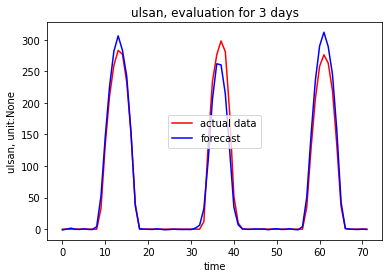

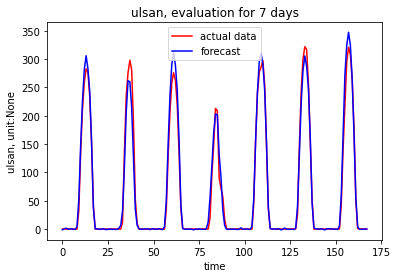

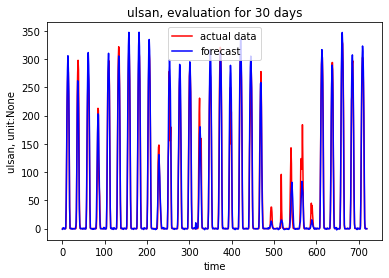

In [ ]:
# ulsan model evaluation
# load model
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
outputs = CNN_LSTM(filters = 128, 
                   kernel_size = 3, 
                   strides = 1, 
                   pool_size = 2, 
                   dropout = 0.2, 
                   units = 256, 
                   n_predict = n_out)(inputs)

model = tf.keras.models.Model(inputs, outputs, name = "CNN_LSTM_model")
model.load_weights("ulsan_weights.h5")

# evaluation
term_3d = range(0, 24 * 3)
term_7d = range(0, 24 * 7)
term_30d = range(0, 24 * 30)

# ulsan prediction
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["ulsan"]
yhats_ulsan = None

d_obs = ulsan_data[x_name].iloc[-24*30*1:].values.reshape(-1, 1, n_timesteps, n_features)
y_real = ulsan_data[y_name].iloc[-24*30*1:].values.reshape(-1,1)
y_pred = model.predict(d_obs).reshape(-1,1)

terms = [term_3d, term_7d, term_30d]
for term in terms:
    day = int(len(term) / 24)
    name = "ulsan, evaluation for " + str(day) + " days"
    plt.plot(y_real[term], 'r', label = "actual data")
    plt.plot(y_pred[term], 'b', label = "forecast")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("ulsan, unit:None")
    plt.title(name)
    plt.show()

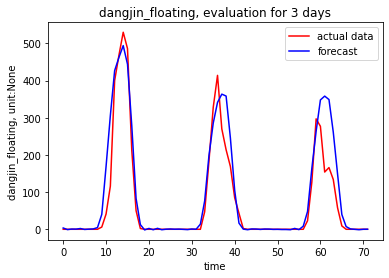

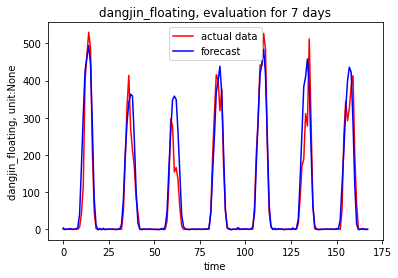

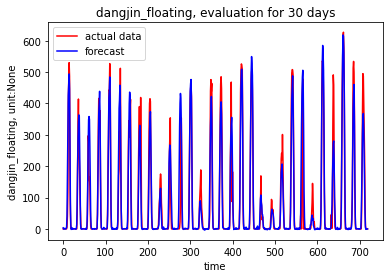

In [ ]:
# dangjin_floating model evaluation
# load model
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
outputs = CNN_LSTM(filters = 128, 
                   kernel_size = 3, 
                   strides = 1, 
                   pool_size = 2, 
                   dropout = 0.2, 
                   units = 512, 
                   n_predict = n_out)(inputs)

model = tf.keras.models.Model(inputs, outputs, name = "CNN_LSTM_model")
model.load_weights("dangjin_floating_weights.h5")

# evaluation
term_3d = range(0, 24 * 3)
term_7d = range(0, 24 * 7)
term_30d = range(0, 24 * 30)

# ulsan prediction
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["dangjin_floating"]

d_obs = dangjin_data[x_name].iloc[-24*30*1:].values.reshape(-1, 1, n_timesteps, n_features)
y_real = dangjin_data[y_name].iloc[-24*30*1:].values.reshape(-1,1)
y_pred = model.predict(d_obs).reshape(-1,1)

terms = [term_3d, term_7d, term_30d]
for term in terms:
    day = int(len(term) / 24)
    name = "dangjin_floating, evaluation for " + str(day) + " days"
    plt.plot(y_real[term], 'r', label = "actual data")
    plt.plot(y_pred[term], 'b', label = "forecast")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("dangjin_floating, unit:None")
    plt.title(name)
    plt.show()

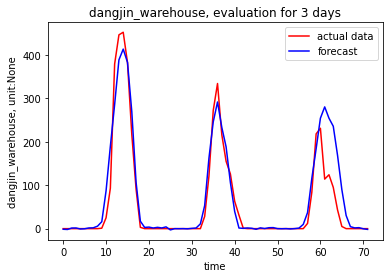

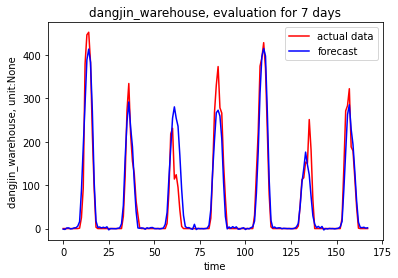

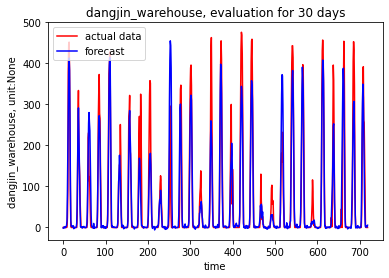

In [ ]:
# dangjin_warehouse model evaluation
# load model
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
outputs = CNN_LSTM(filters = 128, 
                   kernel_size = 3, 
                   strides = 1, 
                   pool_size = 2, 
                   dropout = 0.2, 
                   units = 512, 
                   n_predict = n_out)(inputs)

model = tf.keras.models.Model(inputs, outputs, name = "CNN_LSTM_model")
model.load_weights("dangjin_warehouse_weights.h5")

# evaluation
term_3d = range(0, 24 * 3)
term_7d = range(0, 24 * 7)
term_30d = range(0, 24 * 30)

# ulsan prediction
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["dangjin_warehouse"]

d_obs = dangjin_data[x_name].iloc[-24*30*1:].values.reshape(-1, 1, n_timesteps, n_features)
y_real = dangjin_data[y_name].iloc[-24*30*1:].values.reshape(-1,1)
y_pred = model.predict(d_obs).reshape(-1,1)

terms = [term_3d, term_7d, term_30d]
for term in terms:
    day = int(len(term) / 24)
    name = "dangjin_warehouse, evaluation for " + str(day) + " days"
    plt.plot(y_real[term], 'r', label = "actual data")
    plt.plot(y_pred[term], 'b', label = "forecast")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("dangjin_warehouse, unit:None")
    plt.title(name)
    plt.show()

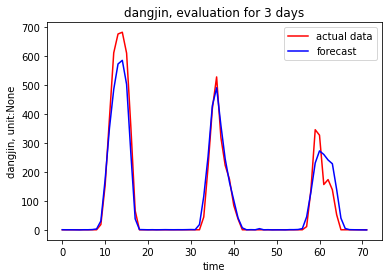

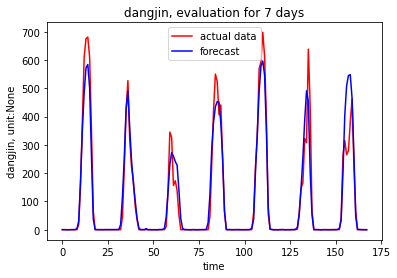

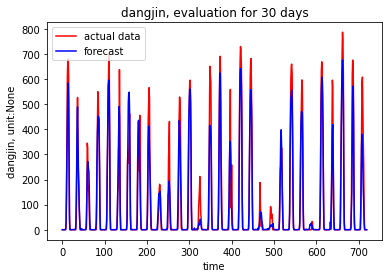

In [ ]:
# dangjin model evaluation
# load model
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
outputs = CNN_LSTM(filters = 128, 
                   kernel_size = 3, 
                   strides = 1, 
                   pool_size = 2, 
                   dropout = 0.2, 
                   units = 512, 
                   n_predict = n_out)(inputs)

model = tf.keras.models.Model(inputs, outputs, name = "CNN_LSTM_model")
model.load_weights("dangjin_weights.h5")

# evaluation
term_3d = range(0, 24 * 3)
term_7d = range(0, 24 * 7)
term_30d = range(0, 24 * 30)

# ulsan prediction
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["dangjin"]

d_obs = dangjin_data[x_name].iloc[-24*30*1:].values.reshape(-1, 1, n_timesteps, n_features)
y_real = dangjin_data[y_name].iloc[-24*30*1:].values.reshape(-1,1)
y_pred = model.predict(d_obs).reshape(-1,1)

terms = [term_3d, term_7d, term_30d]
for term in terms:
    day = int(len(term) / 24)
    name = "dangjin, evaluation for " + str(day) + " days"
    plt.plot(y_real[term], 'r', label = "actual data")
    plt.plot(y_pred[term], 'b', label = "forecast")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("dangjin, unit:None")
    plt.title(name)
    plt.show()

In [ ]:
from google.colab import files
files.download('ulsan_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('dangjin_floating_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('dangjin_warehouse_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('dangjin_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>